In [1]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi
import math
from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile
from glob import glob
import matplotlib.pyplot as plt
# used chatgpt to help me generate some functions

c:\Users\leeku\Desktop\Coding\CSE153_A2\venv\Lib\site-packages\pretty_midi\instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Processing the midi files
midi_files = glob('nes_midis/*')
print(len(midi_files))

#Training the tokenizer
config = TokenizerConfig(num_velocities=1)
tokenizer = REMI(config)
tokenizer.train(vocab_size = 2000, files_paths=midi_files)


2000


In [3]:
instruments = {}
bad_files = []

# Processing the files and making sure midi_files doesn't include any corrupt files
for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        for instrument in midi.instruments:
            name = pretty_midi.program_to_instrument_name(instrument.program)
            instruments[name] = instruments.get(name, 0) + 1
    except Exception as e:
        bad_files.append(file)

sorted_instruments = sorted(instruments.items(), key=lambda x: x[1], reverse=True)
midi_files = [file for file in midi_files if file not in bad_files]


c:\Users\leeku\Desktop\Coding\CSE153_A2\venv\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [4]:


# extracts only the notes where the instruments are useful
def extract_note_sequence(midi_path):
    midi = pretty_midi.PrettyMIDI(midi_path)
    notes = []
    for instrument in midi.instruments:
        if not instrument.is_drum:
            notes += [note.pitch for note in instrument.notes]
    return notes

#extract_notes(midi_files[1])

In [5]:
#processing all the notes for in each midi_file
class MIDIDataset(Dataset):
    def __init__(self, midi_dir, vocab, seq_len=128):
        self.data = []
        self.vocab = vocab
        self.seq_len = seq_len
        self.pitch2idx = {p: i for i, p in enumerate(vocab)}

        for file in midi_dir:
            #print(f"Processing file: {file}")
            notes = extract_note_sequence(file)
            encoded = [self.pitch2idx[n] for n in notes if n in self.pitch2idx]

            for i in range(0, len(encoded) - seq_len):
                x = encoded[i:i + seq_len]
                y = encoded[i+seq_len]
                self.data.append((torch.tensor(x), torch.tensor(y)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



In [6]:
pitch_vocab = sorted(set(p for f in midi_files for p in extract_note_sequence(f)))
pitch2idx = {p: i for i, p in enumerate(pitch_vocab)}
idx2pitch = {i: p for i, p in enumerate(pitch_vocab)}
# vocab = sorted(vocab)

#Process the dataset with our pitch_vocab
dataset = MIDIDataset(midi_dir=midi_files, vocab=pitch_vocab)
print(f"Dataset size: {len(dataset)}") 
# loader = DataLoader(dataset[:1000], batch_size=32, shuffle=True, num_workers=0, pin_memory=True)


Dataset size: 2693807


In [7]:
# LSTM 
class PitchLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # use the last output for prediction
        return out, hidden


In [8]:
# Training the PitchLSTM and calcuating the avg loss and perplexity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
model = PitchLSTM(vocab_size=len(pitch_vocab))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

losses = []
perplexities = []
for epoch in range(12):
    total_loss = 0
    num_batches = 0
    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        out, _ = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    perplexity = math.exp(avg_loss)

    losses.append(avg_loss)
    perplexities.append(perplexity)

    print(f"Epoch {epoch + 1} | Loss: {loss.item():.4f} | Perplexity: {perplexity:.2f}")






Epoch 1 | Loss: 1.3038 | Perplexity: 5.69
Epoch 2 | Loss: 1.3314 | Perplexity: 4.07
Epoch 3 | Loss: 1.1230 | Perplexity: 3.78
Epoch 4 | Loss: 1.2404 | Perplexity: 3.72
Epoch 5 | Loss: 1.2240 | Perplexity: 3.72
Epoch 6 | Loss: 1.5382 | Perplexity: 3.75
Epoch 7 | Loss: 1.3340 | Perplexity: 3.79
Epoch 8 | Loss: 1.3666 | Perplexity: 3.89
Epoch 9 | Loss: 1.5786 | Perplexity: 3.98
Epoch 10 | Loss: 1.9932 | Perplexity: 4.12
Epoch 11 | Loss: 1.4990 | Perplexity: 4.34
Epoch 12 | Loss: 1.9470 | Perplexity: 4.75


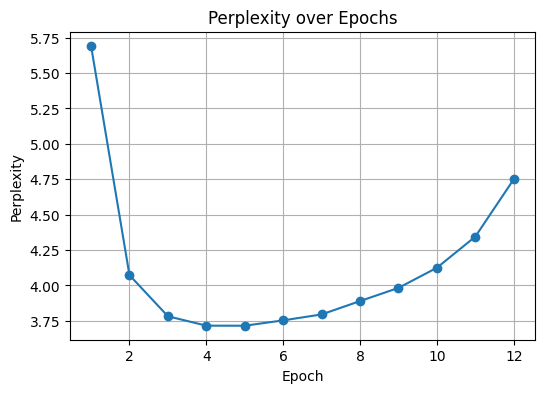

In [9]:
# Plot 1: Perplexity over Epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(perplexities) + 1), perplexities, marker='o')
plt.title("Perplexity over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()


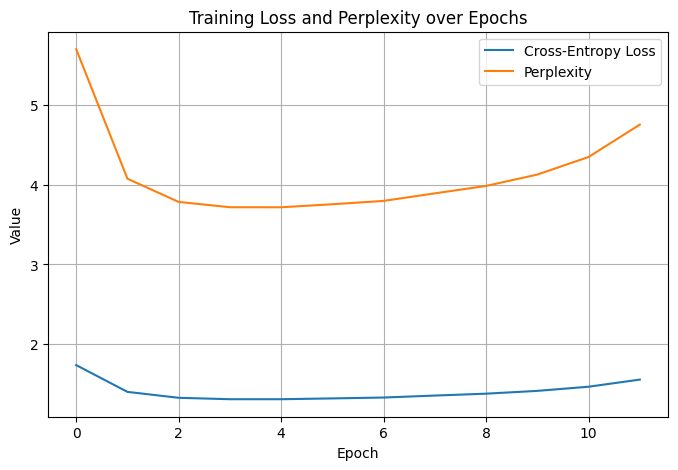

In [10]:
# Plot 2: Cross-Entropy Loss and Perplexity over Steps (optional finer graph)
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Cross-Entropy Loss")
plt.plot(perplexities, label="Perplexity")
plt.title("Training Loss and Perplexity over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Generates a sequence of token indices using a LSTM
def generate_sequence(model, start_seq, length, device):
    model.eval()
    generated = start_seq[:]
    input_seq = torch.tensor(start_seq, dtype=torch.long).unsqueeze(0).to(device)

    hidden = None
    for _ in range(length):
        with torch.no_grad():
            out, hidden = model(input_seq, hidden)
            prob = torch.softmax(out, dim=-1)
            next_token = torch.multinomial(prob, num_samples=1).item()

        generated.append(next_token)
        input_seq = torch.tensor(generated[-len(start_seq):], dtype=torch.long).unsqueeze(0).to(device)

    return generated


In [12]:
# Converts a sequence of pitch tokens into a MIDI file
def sequence_to_midi(token_sequence, idx2pitch, output_path="generated.mid", duration=0.5):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    time = 0

    for token in token_sequence:
        duration = random.choice([0.5, 0.75, 1.0])
        pitch = idx2pitch[token]
        note = pretty_midi.Note(velocity=100, pitch=pitch, start=time, end=time + duration)
        instrument.notes.append(note)
        time += duration

    midi.instruments.append(instrument)
    midi.write(output_path)


In [15]:
# 1. First random seed
start_seq = [random.choice(range(len(pitch_vocab))) for _ in range(32)]
first_part = generate_sequence(model, start_seq, length=200, device=device)

# 2. Use last 32 tokens from the first as the new seed
second_seed = first_part[-32:]
second_part = generate_sequence(model, second_seed, length=200, device=device)

# 3. Combine the two parts
final_tokens = second_part

# 4. Save as MIDI
sequence_to_midi(final_tokens, idx2pitch, output_path="symbolic_unconditioned.mid")
